In [ ]:
import matplotlib.pyplot as plt
import networkx as nx
import pandas as pd
import numpy as np
from networkx.algorithms import approximation
from networkx.algorithms import distance_measures
import math
import os
import sys
from docplex.mp.model import Model  #import the Model class from docplex.mp

In [3]:
# path

n = 50

path ='./'
data_path = path + 'Inputs/G'+str(n)+'.txt'  
result_path = path +'Outputs/G'+str(n)+'_SI_result.txt'

In [ ]:
# read data

edges=[];
es = [];
with open(data_path, 'r') as f:
    lines = f.readlines()
    # n= int(lines[0]) 
    for line in lines:
        #temp = []
        #print(line.split())
        edges.append((int(line.split()[0]),int(line.split()[1])))
        es.append((int(line.split()[0])-1,int(line.split()[1])-1)) #change indices  1..14 ==> 0..13
# print(n,len(edges),edges)

[(1, 2), (1, 3), (1, 12), (1, 33), (2, 3), (2, 15), (2, 47), (3, 44), (3, 14), (3, 18), (3, 20), (3, 16), (12, 22), (12, 42), (33, 22), (33, 32), (33, 48), (15, 10), (15, 17), (15, 48), (47, 16), (47, 19), (47, 28), (47, 48), (44, 8), (44, 35), (44, 43), (44, 46), (14, 16), (18, 11), (18, 13), (18, 17), (18, 19), (18, 40), (18, 32), (20, 23), (16, 35), (16, 49), (4, 24), (4, 7), (4, 34), (24, 23), (24, 25), (24, 26), (7, 5), (7, 6), (7, 9), (34, 35), (34, 36), (5, 6), (5, 9), (6, 8), (6, 46), (6, 41), (9, 10), (8, 19), (8, 13), (8, 37), (46, 22), (46, 27), (46, 29), (46, 43), (41, 25), (41, 28), (41, 35), (41, 39), (41, 45), (19, 10), (13, 39), (13, 23), (13, 31), (37, 17), (37, 36), (37, 43), (10, 35), (10, 45), (35, 36), (11, 25), (25, 21), (25, 26), (25, 38), (22, 17), (42, 40), (42, 43), (23, 21), (31, 30), (31, 38), (17, 26), (48, 29), (48, 50), (49, 27), (26, 50), (26, 36), (40, 21), (40, 38), (32, 30), (38, 27), (38, 36), (50, 28), (27, 28)]


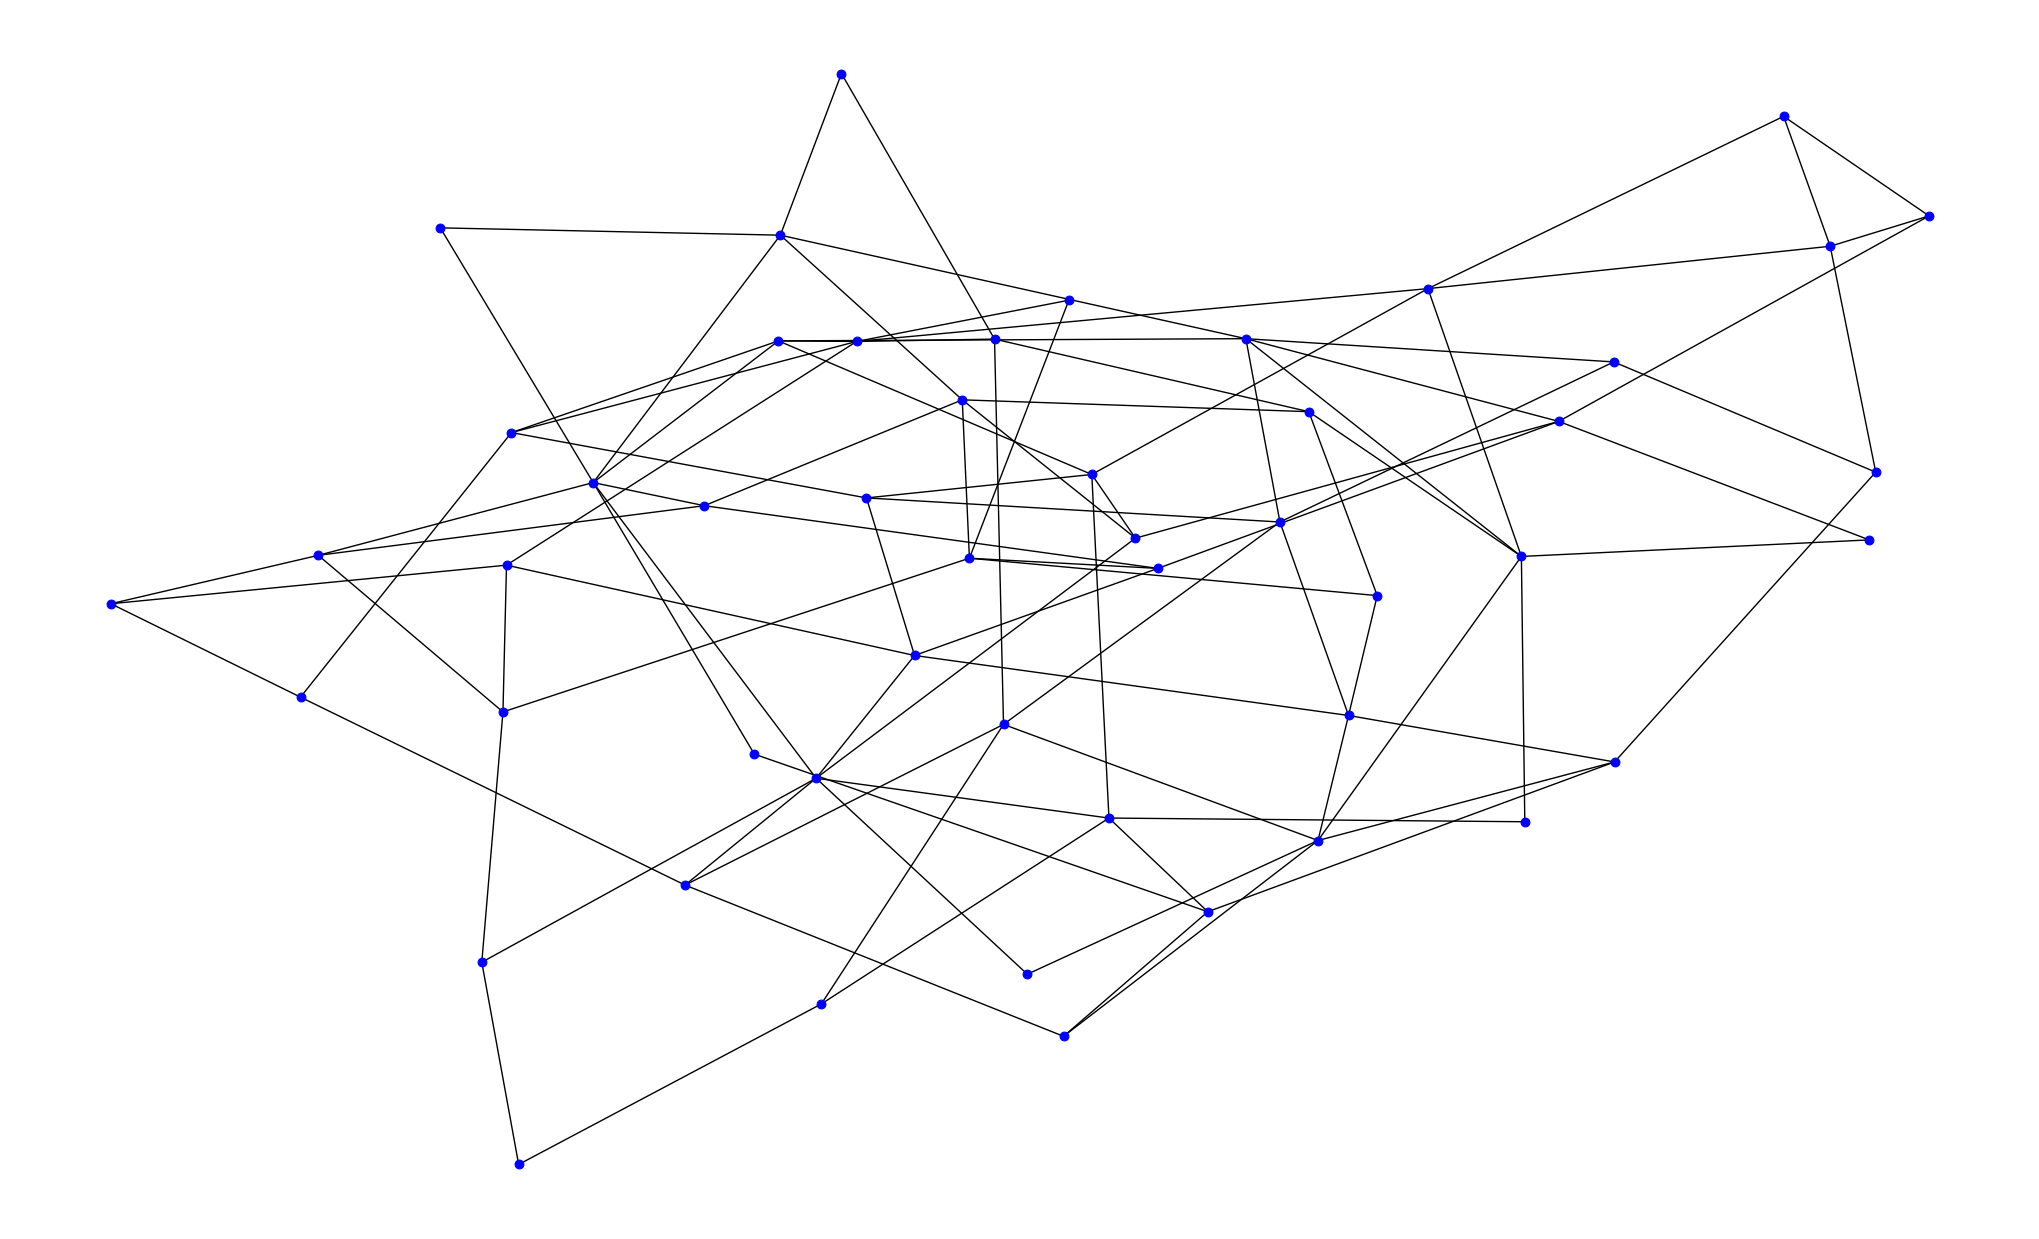

In [5]:
# creat the graph
G=nx.Graph()

# add a list of edges
G.add_edges_from(edges)

# print(G.edges())

edges = list(G.edges())

# draw the graph, place the nodes using x,y coordinates
plt.figure(figsize=(10,6), dpi=200) 
nx.draw(G, node_size=10, with_labels=False, node_color='blue',linewidths=0.4,width = 0.5)

# neighbors of i
nbs={i:{j for j in range(1,n+1) if ((i,j) in edges) | ((j,i) in edges)}for i in range(1,n+1)}

# show plot
plt.show()

In [ ]:
import random

# split data
def data_split(full_list, ratio=0.5, shuffle=False):
    """
     Data splitting: divide the full_list into 2 sublists: sublist_1 and sublist_2 according to the ratio (randomly)
    :param full_list: vertex set V
    :param ratio:    default: 0.5
    :param shuffle:  True or False 
    :return: sublist1,sublist2
    """
    n_total = len(full_list)
    offset = int(n_total * ratio)
    if n_total == 0 or offset < 1:
        return [], full_list
    if shuffle:
        random.shuffle(full_list)
    sublist_1 = full_list[:offset]
    sublist_2 = full_list[offset:]
    return sublist_1, sublist_2 

In [ ]:
# networks G,G1,G2 

data = list(range(1,n+1))
V = data
# V1, V2 = data_split(data, ratio=0.5, shuffle=True)

V1=[16, 38, 49, 2, 5, 26, 12, 50, 7, 48, 41, 29, 23, 39, 20, 10, 47, 42, 8, 11, 1, 34, 30, 21, 4]
V2=[46, 14, 22, 9, 36, 44, 37, 3, 32, 17, 31, 33, 43, 27, 6, 35, 19, 25, 24, 40, 18, 13, 45, 28, 15]

In [9]:
# parameters

## edge weight

a = 0.015
b = 0.05
c = 0.3
d = 0.9

a = np.log(1/(1-a))
b = np.log(1/(1-b))
c = np.log(1/(1-c))
d = np.log(1/(1-d))


'''
w = {(i,j):a for i in V1 for j in V1}
w.update({(i,j):b for i in V1 for j in V2})
w.update({(i,j):c for i in V2 for j in V1})
w.update({(i,j):d for i in V2 for j in V2})
w
'''
w = {(i,j):a for i in V1 for j in nbs[i] if j in V1}
w.update({(i,j):b for i in V1 for j in nbs[i] if j in V2})
w.update({(i,j):c for i in V2 for j in nbs[i] if j in V1})
w.update({(i,j):d for i in V2 for j in nbs[i] if j in V2})
# print(len(w))

############################## 

T = 25 # time period
B = 5 # budget
s = 0.99 # threshold
s = np.log(1/(1-s))
M = 9999

200


In [10]:
def SI(B):
    # SI optimization model

    # create the model
    m =Model()

    # create variables
    x = m.binary_var_matrix(range(1,n+1), range(T+1), "x")


    # objective function

    obj=m.sum(x[i,T] for i in V)
    #print(obj)

    # add constraints

    constr1 = m.sum(x[i,0]  for i in V) <=B   
    m.add_constraint(constr1)


    constr2 = [m.sum(x[j,k-1]*w[j,i] for k in range(max(1,1),t+1) for j in nbs[i])>=s*(x[i,t]-x[i,t-1]) for i in V for t in range(1,T+1)]
    m.add_constraints(constr2)


    constr3 = [m.sum(x[j,k-1]*w[j,i] for k in range(max(1,1),t+1) for j in nbs[i])<=s+ M*x[i,t] for i in V for t in range(1,T+1)]
    m.add_constraints(constr3)

    constr4 = [x[i,t-1]<=x[i,t] for i in V for t in range(1,T+1)]
    m.add_constraints(constr4)


    # print information
    m.print_information()


    # maximize the obj
    m.maximize(obj)
    
    # export model
    #m.export_as_lp(path+"Outputs/G"+str(n)+'_'+str(B)+"_SI_output.lp")

    # solve model
    fp = open(path+'Outputs/G'+str(n)+'_'+str(B)+'_SI_log.txt', "w+")
    solution = m.solve(log_output=fp)
    print(solution.objective_value)
    fp.close()
    
    # write the result
    with open(path+'Outputs/G'+str(n)+'_'+str(B)+'_SI_result.txt', 'w+') as f:
        f.write('Total (root+branch&cut) =  {:.2f} sec.'.format(solution.solve_details.time)+'\n')
        f.write('Parameters B: {}  T : {}'.format(B,T)+'\n')
        f.write('The optimal value is: {}'.format(solution.objective_value)+'\n')
        #f.writelines(str(solution.display()))
        f.write('The optimal solution is: ')
        for i in range(1,n+1):
            if solution[x[(i,0)]]:
                f.write(str(i)+' ')
                
    return list([sum(solution[x[i,t]] for i in V) for t in range(T+1)])

In [11]:
SI_infected = []
for B in [3,5,9]:    
    SI_infected = SI_infected + [SI(B)] 

Model: docplex_model1
 - number of variables: 1300
   - binary=1300, integer=0, continuous=0
 - number of constraints: 3751
   - linear=3751
 - parameters: defaults
 - objective: none
 - problem type is: MILP
49.0
Model: docplex_model2
 - number of variables: 1300
   - binary=1300, integer=0, continuous=0
 - number of constraints: 3751
   - linear=3751
 - parameters: defaults
 - objective: none
 - problem type is: MILP
50.0
Model: docplex_model3
 - number of variables: 1300
   - binary=1300, integer=0, continuous=0
 - number of constraints: 3751
   - linear=3751
 - parameters: defaults
 - objective: none
 - problem type is: MILP
50.0


In [12]:
for B in [3,5,9]:    
    with open(path+'Outputs/G'+str(n)+'_'+str(B)+'_SI_result.txt', 'r') as f:
        lines = f.readlines()
    print(lines)

['Total (root+branch&cut) =  12.66 sec.\n', 'Parameters B: 3  T : 25\n', 'The optimal value is: 49.0\n', 'The optimal solution is: 22 25 45 ']
['Total (root+branch&cut) =  28.15 sec.\n', 'Parameters B: 5  T : 25\n', 'The optimal value is: 50.0\n', 'The optimal solution is: 9 17 18 25 45 ']
['Total (root+branch&cut) =  15.87 sec.\n', 'Parameters B: 9  T : 25\n', 'The optimal value is: 50.0\n', 'The optimal solution is: 3 9 15 18 24 27 33 35 45 ']


[[ 3.  3.  6.  7.  7. 14. 17. 21. 25. 28. 31. 33. 34. 38. 41. 43. 43. 43.
  46. 47. 48. 49. 49. 49. 49. 49.]
 [ 5.  5. 11. 14. 21. 24. 28. 30. 33. 35. 41. 42. 43. 43. 43. 46. 47. 48.
  48. 49. 50. 50. 50. 50. 50. 50.]
 [ 9. 11. 20. 23. 25. 29. 31. 34. 37. 40. 43. 43. 43. 46. 46. 49. 50. 50.
  50. 50. 50. 50. 50. 50. 50. 50.]]


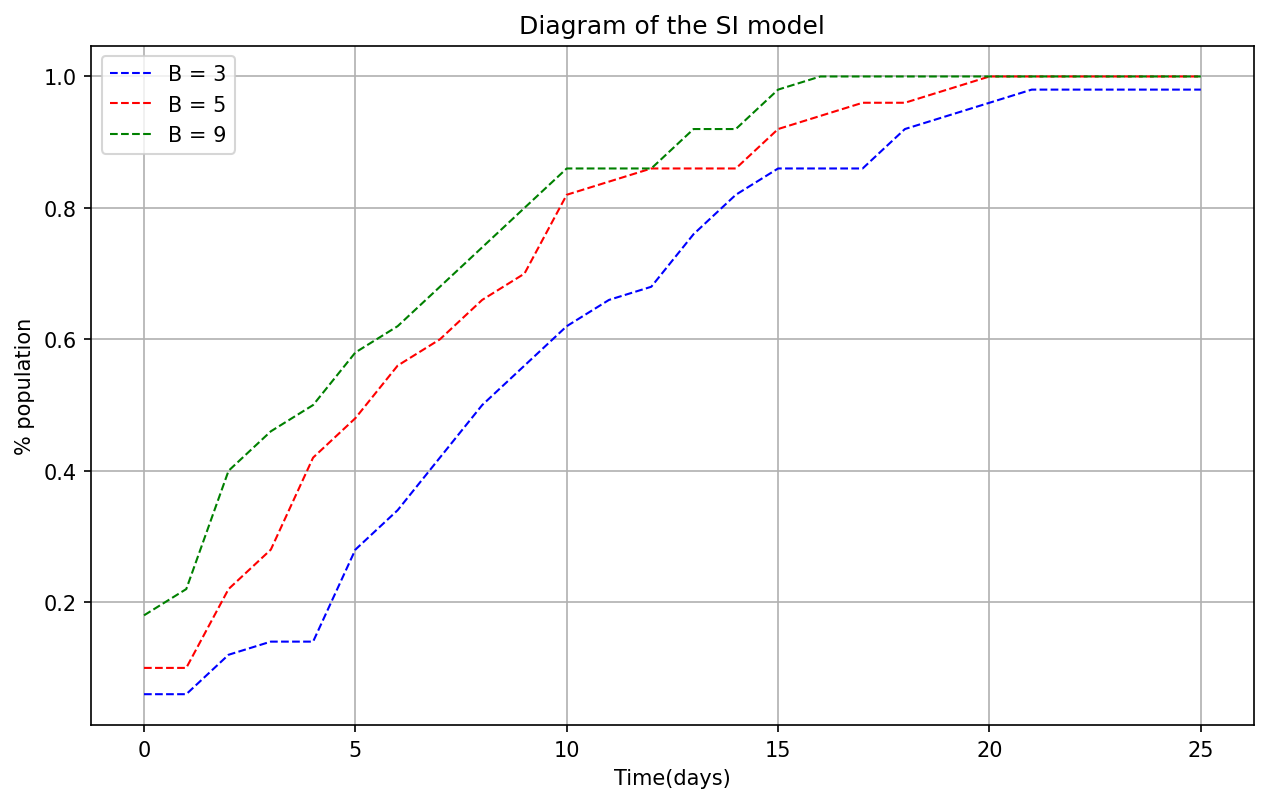

In [13]:
# plot output

time = list(range(T+1))

SI_infected = np.array(SI_infected)
# print(SI_infected)

plt.figure(figsize=(10,6),dpi=150) #create a figure
plt.plot(time,SI_infected[0]/n,"b--",color = 'b', linewidth=1, label = 'B = 3')  
plt.plot(time,SI_infected[1]/n,"r--", linewidth=1, label = 'B = 5')
plt.plot(time,SI_infected[2]/n,"g--", linewidth=1, label = 'B = 9')
plt.xlabel("Time(days)") #x labels
plt.ylabel("% population") 
plt.title('Diagram of the SI model')
plt.legend(loc = "best")
# plt.xlim((0,60))

# save plot
plt.savefig(path+'Outputs/G'+str(n)+"_SI_curves.jpg")

plt.grid()

# show plot
plt.show()  
